# Signate開始時のお約束

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [64]:
!pip install signate

In [65]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [66]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [67]:
!pip install kanjize

In [68]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [69]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [70]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-70-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

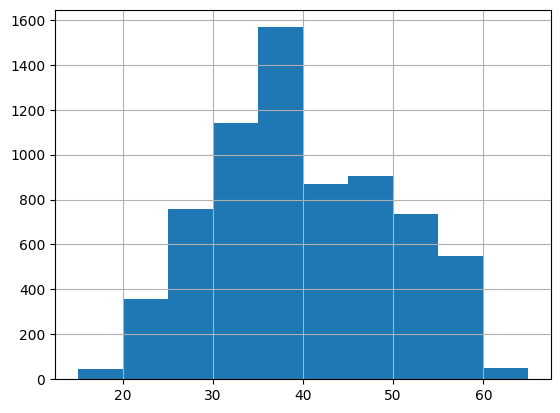

In [71]:
all_df["Age"].hist()

In [72]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [73]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [74]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [75]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

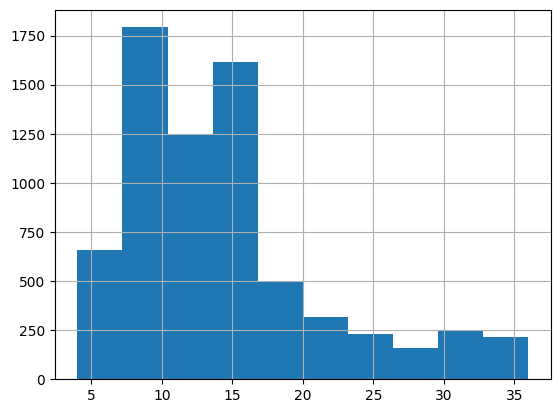

In [76]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [77]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [78]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [79]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [80]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [81]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [82]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [83]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [84]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [85]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [86]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"
    # all_df.loc[i,"ProductPitched"] = 1

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"
    # all_df.loc[i,"ProductPitched"] = 2

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"
    # all_df.loc[i,"ProductPitched"] = 3

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"
    # all_df.loc[i,"ProductPitched"] = 4

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"
    # all_df.loc[i,"ProductPitched"] = 5

  else:
    others.append(i)

In [87]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [88]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [89]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

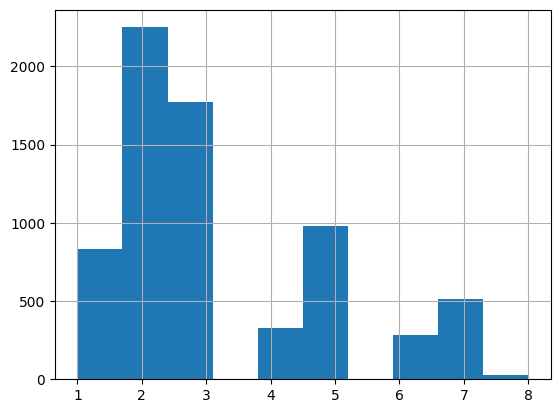

In [90]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [91]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

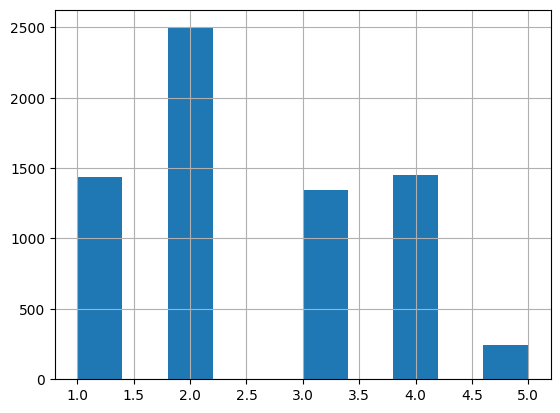

In [92]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [93]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [94]:
# Executive: 取締役、執行役員
# VP: 副社長、本部長
# AVP: 副社長補佐
# Senior Manager: 課長、次長
# Manager: 課長
# col = []

# for i in range(max_row):

#   if(all_df.loc[i,"Designation"] not in col):
#     col.append(all_df.loc[i,"Designation"])

In [95]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [96]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"
    # all_df.loc[i,"Designation"] = 5

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"
    # all_df.loc[i,"Designation"] = 4

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"
    # all_df.loc[i,"Designation"] = 3

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"
    # all_df.loc[i,"Designation"] = 2

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"
    # all_df.loc[i,"Designation"] = 1

In [97]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [98]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

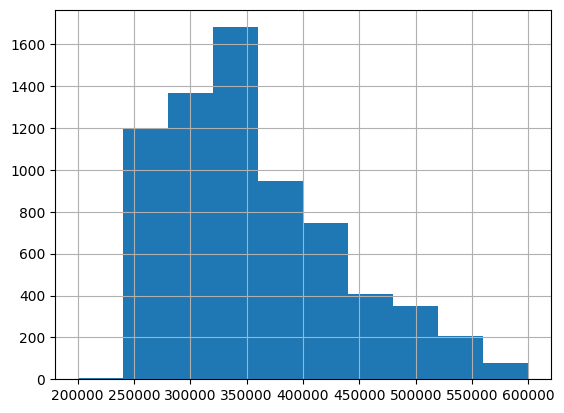

In [99]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [100]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [101]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [102]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [103]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [104]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [105]:
####################
# 新たな特徴を追加 #
####################
# 1. all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]
# 2. all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 3. all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 4. all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]
# 5. all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]
# 6. all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]
# 7. all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]
# 8. all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]
# 9. all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]
# 10. all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]
# 11. all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]
# 12. all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]
# 13. all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]
# 14. all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# 15. all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]
# 16. all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]
# 17. all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]
# 18. all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [106]:
pip install -U scikit-learn

In [107]:
from sklearn.preprocessing import OrdinalEncoder
# oe = preprocessing.OrdinalEncoder()
oe = OrdinalEncoder()
# all_df["Designation_LE"] = oe.fit_transform(all_df["Designation"].values.reshape(-1,1))
# all_df["Occupation_LE"] = oe.fit_transform(all_df["Occupation"].values.reshape(-1,1))
# all_df["Gender_LE"] = oe.fit_transform(all_df["Gender"].values.reshape(-1,1))
# all_df["ProductPitched_LE"] = oe.fit_transform(all_df["ProductPitched"].values.reshape(-1,1))
# all_df["Married_LE"] = oe.fit_transform(all_df["Married"].values.reshape(-1,1))
# all_df["TypeofContact_LE"] = oe.fit_transform(all_df["TypeofContact"].values.reshape(-1,1))

#------------------------------------------------------------------------------------
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Designation"]
  if(term=="Executive"):
    all_df.loc[i,"Designation_LE"] = 5
  elif(term=="VP"):
    all_df.loc[i,"Designation_LE"] = 4
  elif(term=="AVP"):
    all_df.loc[i,"Designation_LE"] = 3
  elif(term=="Senior Manager"):
    all_df.loc[i,"Designation_LE"] = 2
  elif(term=="Manager"):
    all_df.loc[i,"Designation_LE"] = 1

#------------------------------------------------------------------------------------
# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Occupation"]
  if(term=="Large Business"):
    all_df.loc[i,"Occupation_LE"] = 3
  elif(term=="Small Business"):
    all_df.loc[i,"Occupation_LE"] = 2
  elif(term=="Salaried"):
    all_df.loc[i,"Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

#------------------------------------------------------------------------------------
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Gender"]
  if(term=="Female"):
    all_df.loc[i,"Gender_LE"] = 2
  elif(term=="Male"):
    all_df.loc[i,"Gender_LE"] = 1

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"ProductPitched"]
  if(term=="King"):
    all_df.loc[i,"ProductPitched_LE"] = 5
  elif(term=="SuperDeluxe"):
    all_df.loc[i,"ProductPitched_LE"] = 4
  elif(term=="Deluxe"):
    all_df.loc[i,"ProductPitched_LE"] = 3
  elif(term=="Standard"):
    all_df.loc[i,"ProductPitched_LE"] = 2
  elif(term=="Basic"):
    all_df.loc[i,"ProductPitched_LE"] = 1

#------------------------------------------------------------------------------------
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"Married"]
  if(term=="Married"):
    all_df.loc[i,"Married_LE"] = 3
  elif(term=="Divorce"):
    all_df.loc[i,"Married_LE"] = 2
  elif(term=="Single"):
    all_df.loc[i,"Married_LE"] = 1

# 「TypeofContact」をラベルエンコード-----------------------------
all_df["TypeofContact_LE"] = 1

for i in range(len(all_df)):
  term = all_df.loc[i,"TypeofContact"]
  if(term=="Company Invited"):
    all_df.loc[i,"TypeofContact_LE"] = 2
  elif(term=="Self Enquiry"):
    all_df.loc[i,"TypeofContact_LE"] = 1
#-----------------------------------------------------------------

# 1.「Age」×「MonthlyIncome」 (若年高収入 or 高齢低収入)
all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]

# 2.「MonthlyIncome」×「CityTier」 (地域と収入のミスマッチ度)
all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]

# 3.「Designation」×「MonthlyIncome」 (実際の報酬と役職の一致度(過小/過大評価)
all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]

# 4.「Occupation」×「CarHolder」 (経済属性の組み合わせ)
all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]

# 5.「Occupation」×「DurationOfPitch」 (ターゲット層ごとの営業効果の違い)
all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]

# 6.「Gender」×「ProductPitched」 (商品嗜好の違いを反映)
all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]

# 7.「Married」×「NumofChild」 (家庭環境の圧縮表現)
all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]

# 8.「Married」×「NumberOfFollowups」 (家族持ち層のフォロー行動の傾向分析)
all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]

# 9.「NumberOfTrips」×「PreferredPropertyStar」 (旅行慣れ層の嗜好)
all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]

# 10.「Passport」×「CitytTier」 (国際経験と居住地との関係性)
all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]

# 11.「PrefferedPropertyStar」×「PitchSatisfactionScore」 (高級志向と満足度の関係性)
all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]

# 12.「ProductPitched」×「NumberOfTrips」 (リピーターに対する商品設計の効き方)
all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]

# 13.「TypeofContact」×「NumberOfFollowups」 (コンタクトチャネルの最適性分析)
all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]

# 14.「DurationPitched」×「PitchSatisfactionScore」 (営業時間と結果の相関分析)
all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]

# 15.「TypeofContact」×「Age」 (高齢層に対する適切なチャネル分析)
all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]

# 16.(「MonthlyIncome」 ÷ 「CityTier」) × NumberOfTrips = 地域あたり可処分所得の旅行傾向
all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]

# 17.「Age」×「PitchSatisfactionScore」×「NumberOfFollowups」 = 長期的関係性の影響
all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]

# 18.「NumofChild」×「PreferredPropertyStar」 = 家族連れの高級志向傾向の抽出
all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [108]:
# 使用済みのラベルは抹消する
all_df = all_df.drop("Designation_LE", axis=1)
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)
all_df = all_df.drop("ProductPitched_LE", axis=1)
all_df = all_df.drop("Married_LE", axis=1)
all_df = all_df.drop("TypeofContact_LE", axis=1)

In [109]:
# 重要度の低いラベルは抹消する
# all_df = all_df.drop("Married_times_NumChild", axis=1)
# all_df = all_df.drop("NumTrips_times_PropStar", axis=1)
# all_df = all_df.drop("Contact_times_NumFollow", axis=1)
# all_df = all_df.drop("NumChild_times_PropStar", axis=1)
# all_df = all_df.drop("TypeofContact", axis=1)
# all_df = all_df.drop("CarHolder", axis=1)
# all_df = all_df.drop("Gender", axis=1)

In [110]:
# 1. all_df["Age_times_Income"] = all_df["Age"] * all_df["MonthlyIncome"]
# 2. all_df["Income_times_Tier"] = all_df["MonthlyIncome"] * all_df["CityTier"]
# 3. all_df["Desig_times_Income"] = all_df["Designation_LE"] * all_df["MonthlyIncome"]
# 4. all_df["Occu_times_Car"] = all_df["Occupation"] * all_df["CarHolder"]
# 5. all_df["Occu_times_DurPitch"] = all_df["Occupation_LE"] * all_df["DurationOfPitch"]
# 6. all_df["Gen_times_ProPitch"] = all_df["Gender_LE"] * all_df["ProductPitched_LE"]
# 7. all_df["Married_times_NumChild"] = all_df["Married_LE"] * all_df["NumofChild"]
# 8. all_df["Married_times_NumFollow"] = all_df["Married_LE"] * all_df["NumberOfFollowups"]
# 9. all_df["NumTrips_times_PropStar"] = all_df["NumberOfTrips"] * all_df["PreferredPropertyStar"]
# 10. all_df["Pass_times_Tier"] = all_df["Passport"] * all_df["CityTier"]
# 11. all_df["PropStar_times_Satisfac"] = all_df["PreferredPropertyStar"] * all_df["PitchSatisfactionScore"]
# 12. all_df["ProPitch_times_Trip"] = all_df["ProductPitched"] * all_df["NumberOfTrips"]
# 13. all_df["Contact_times_NumFollow"] = all_df["TypeofContact_LE"] * all_df["NumberOfFollowups"]
# 14. all_df["DurPitch_times_Satisfac"] = all_df["DurationOfPitch"] * all_df["PitchSatisfactionScore"]
# 15. all_df["Contact_times_Age"] = all_df["TypeofContact_LE"] * all_df["Age"]
# 16. all_df["Income_times_Tier_by_Trip"] = all_df["MonthlyIncome"] / all_df["CityTier"] * all_df["NumberOfTrips"]
# 17. all_df["Age_times_Satisfac_times_NumFollow"] = all_df["Age"] * all_df["PitchSatisfactionScore"] * all_df["NumberOfFollowups"]
# 18. all_df["NumChild_times_PropStar"] = all_df["NumofChild"] * all_df["PreferredPropertyStar"]

In [111]:
# 取り除く変数
RMV = ["id","ProdTaken"]

# 使用する変数を制限
FEATURES = ["Age",
            "TypeofContact",
            "CityTier","DurationOfPitch","Occupation",
            "Gender",
            "NumberOfPersonVisiting","NumberOfFollowups","ProductPitched",
            "PreferredPropertyStar","NumberOfTrips","Passport","PitchSatisfactionScore","MonthlyIncome",
            "CarHolder",
            "Married","NumofChild","Designation",
            "Age_times_Income","Income_times_Tier","Desig_times_Income","Occu_times_Car","Occu_times_DurPitch","Gen_times_ProPitch",
            "Married_times_NumChild",
            "Married_times_NumFollow",
            "NumTrips_times_PropStar",
            "Pass_times_Tier","PropStar_times_Satisfac",
            "ProPitch_times_Trip",
            "Contact_times_NumFollow",
            "DurPitch_times_Satisfac","Contact_times_Age","Income_times_Tier_by_Trip",
            "Age_times_Satisfac_times_NumFollow",
            "NumChild_times_PropStar",
            "ProdTaken"]

# FEATURES = ["Age","TypeofContact","CityTier","DurationOfPitch","Occupation","Gender","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched",
#             "PreferredPropertyStar","NumberOfTrips","Passport","PitchSatisfactionScore","MonthlyIncome","CarHolder","Married","NumofChild","Designation",
#             "Age_times_Income","Income_times_Tier","Desig_times_Income","Occu_times_Car","Occu_times_DurPitch","Gen_times_ProPitch",
#             "Married_times_NumChild","Married_times_NumFollow","NumTrips_times_PropStar","Pass_times_Tier","PropStar_times_Satisfac",
#             "ProPitch_times_Trip","Contact_times_NumFollow","DurPitch_times_Satisfac","Contact_times_Age","Income_times_Tier_by_Trip",
#             "Age_times_Satisfac_times_NumFollow","NumChild_times_PropStar",
#             "ProdTaken"]


TARGET = "ProdTaken"

In [112]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [113]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [114]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)

<ipython-input-114-6f97bd2ef6e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df2[CATS] = oe.fit_transform(all_df2[CATS].values)


In [115]:
# one-hot
# all_df2 = pd.get_dummies(all_df2, columns=CATS)

In [116]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [117]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [118]:
FEATURES = test.columns

In [119]:
# import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
# from xgboost import XGBRegressor, XGBClassifier
# import xgboost
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7310002414300506, # 7回
    'num_leaves': 9, # 20回
    'bagging_fraction': 0.46766930795838424,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    'lambda_l1': 2.5822011957418005,
    'lambda_l2': 7.210420837783116,
    'min_data_in_leaf': 47,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [120]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.922832	valid's auc: 0.838442
#########################
### Fold 2
#########################
[100]	train's auc: 0.933766	valid's auc: 0.810943
#########################
### Fold 3
#########################
[100]	train's auc: 0.927465	valid's auc: 0.836657
CPU times: user 14.5 s, sys: 307 ms, total: 14.8 s
Wall time: 2.36 s


In [121]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8282415078707539


In [122]:
# importanceを表示する
importance = pd.DataFrame(models[1].feature_importance(importance_type="gain"),
                          index=test.columns,columns=['importance'])
importance = importance.sort_values("importance", ascending=False)
display(importance)

,importance
ProductPitched,79.489784
Age_times_Income,68.694985
Gen_times_ProPitch,53.896094
Married,47.439209
MonthlyIncome,40.609757
Desig_times_Income,24.896628
Pass_times_Tier,18.743769
Passport,17.846907
Age,13.830989
Income_times_Tier,12.456656


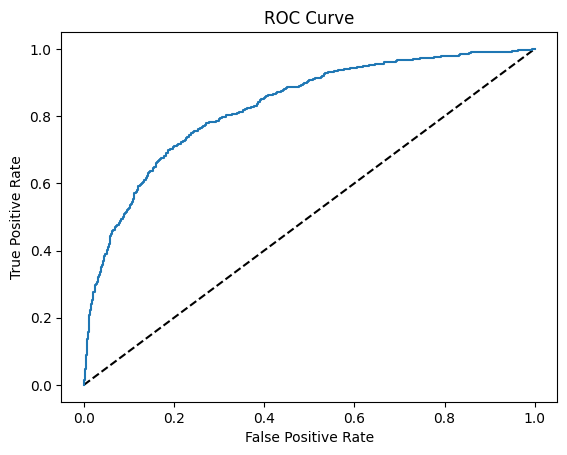

In [123]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [124]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00


In [137]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
      'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  FOLDS = 3 # 分割数
  kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-05-19 12:13:42,646] A new study created in memory with name: no-name-ec0b6a96-0783-4cfb-965c-94b2859ea79e
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.961448	valid's auc: 0.829669
#########################
### Fold 2
#########################
[100]	train's auc: 0.96326	valid's auc: 0.800362
#########################
### Fold 3
#########################
[100]	train's auc: 0.964275	valid's auc: 0.815887


[I 2025-05-19 12:13:43,292] Trial 0 finished with value: 0.8241487696230863 and parameters: {'feature_fraction': 0.7071629260472319, 'num_leaves': 153, 'bagging_fraction': 0.7599623035618572, 'lambda_l1': 1.5836956043836958, 'lambda_l2': 2.271000129783024, 'min_data_in_leaf': 83}. Best is trial 0 with value: 0.8241487696230863.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.999851	valid's auc: 0.793785
#########################
### Fold 2
#########################
[100]	train's auc: 0.999665	valid's auc: 0.775719
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:44,266] Trial 1 finished with value: 0.8052839093383832 and parameters: {'feature_fraction': 0.7782824712993308, 'num_leaves': 73, 'bagging_fraction': 0.5682436974419969, 'lambda_l1': 0.5089211313959684, 'lambda_l2': 2.327708800321825, 'min_data_in_leaf': 27}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.999917	valid's auc: 0.787674
#########################
### Fold 1
#########################
[100]	train's auc: 0.89859	valid's auc: 0.838951
#########################
### Fold 2
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-19 12:13:44,717] Trial 2 finished with value: 0.8208519163106984 and parameters: {'feature_fraction': 0.9852745874608, 'num_leaves': 172, 'bagging_fraction': 0.6210868260991296, 'lambda_l1': 7.67201570881291, 'lambda_l2': 7.273773374299626, 'min_data_in_leaf': 74}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.906461	valid's auc: 0.802699
#########################
### Fold 3
#########################
[100]	train's auc: 0.901036	valid's auc: 0.830148
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.946727	valid's auc: 0.834221
#########################
### Fold 2
#########################
[100]	train's auc: 0.950672	valid's auc: 0.804237
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:45,321] Trial 3 finished with value: 0.8239107102508098 and parameters: {'feature_fraction': 0.4846858891520925, 'num_leaves': 255, 'bagging_fraction': 0.8684311990865221, 'lambda_l1': 4.9413140809687315, 'lambda_l2': 2.472193429904911, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.948179	valid's auc: 0.827173
#########################
### Fold 1
#########################
[100]	train's auc: 0.989057	valid's auc: 0.818276


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.988754	valid's auc: 0.795399
#########################
### Fold 3
#########################
[100]	train's auc: 0.988608	valid's auc: 0.804541


[I 2025-05-19 12:13:46,074] Trial 4 finished with value: 0.821125617340406 and parameters: {'feature_fraction': 0.7009276279752276, 'num_leaves': 74, 'bagging_fraction': 0.7472600904955788, 'lambda_l1': 0.6322727601624818, 'lambda_l2': 4.151735721743438, 'min_data_in_leaf': 56}. Best is trial 1 with value: 0.8052839093383832.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.968817	valid's auc: 0.830515
#########################
### Fold 2
#########################
[100]	train's auc: 0.96868	valid's auc: 0.805403
#########################
### Fold 3
#########################
[100]	train's auc: 0.968151	valid's auc: 0.82643


[I 2025-05-19 12:13:46,789] Trial 5 finished with value: 0.8276920883590312 and parameters: {'feature_fraction': 0.4828744231905185, 'num_leaves': 149, 'bagging_fraction': 0.5303050725986348, 'lambda_l1': 2.6129254660210197, 'lambda_l2': 0.790150839394876, 'min_data_in_leaf': 52}. Best is trial 1 with value: 0.8052839093383832.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.963003	valid's auc: 0.820018
#########################
### Fold 2
#########################
[100]	train's auc: 0.968992	valid's auc: 0.798813
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:47,431] Trial 6 finished with value: 0.8224251928684405 and parameters: {'feature_fraction': 0.9574295705179511, 'num_leaves': 23, 'bagging_fraction': 0.8365103438369192, 'lambda_l1': 1.4215027640765034, 'lambda_l2': 2.2283558662123464, 'min_data_in_leaf': 87}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.966766	valid's auc: 0.824159
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.979027	valid's auc: 0.831282
#########################
### Fold 2
#########################
[100]	train's auc: 0.980462	valid's auc: 0.790558
#########################
### Fold 3
#########################
[100]	train's auc: 0.978841	valid's auc: 0.811208


[I 2025-05-19 12:13:48,068] Trial 7 finished with value: 0.8221548542592454 and parameters: {'feature_fraction': 0.7972911106336324, 'num_leaves': 117, 'bagging_fraction': 0.909035111962896, 'lambda_l1': 0.38506018997543673, 'lambda_l2': 4.291906557021244, 'min_data_in_leaf': 77}. Best is trial 1 with value: 0.8052839093383832.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.899102	valid's auc: 0.842362
#########################
### Fold 2
#########################


[I 2025-05-19 12:13:48,551] Trial 8 finished with value: 0.8233663343698555 and parameters: {'feature_fraction': 0.6384555201097508, 'num_leaves': 155, 'bagging_fraction': 0.7276347110774349, 'lambda_l1': 6.592440203920865, 'lambda_l2': 2.875491772114135, 'min_data_in_leaf': 91}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.90509	valid's auc: 0.811109
#########################
### Fold 3
#########################
[100]	train's auc: 0.903568	valid's auc: 0.827502
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.951341	valid's auc: 0.828724
#########################
### Fold 2
#########################
[100]	train's auc: 0.946295	valid's auc: 0.796232
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:49,032] Trial 9 finished with value: 0.8139700502480122 and parameters: {'feature_fraction': 0.818176249421296, 'num_leaves': 214, 'bagging_fraction': 0.5337676677357428, 'lambda_l1': 5.682351594155664, 'lambda_l2': 3.34223835444921, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.941203	valid's auc: 0.827851
#########################
### Fold 1
#########################
[100]	train's auc: 0.854547	valid's auc: 0.84734
[200]	train's auc: 0.870529	valid's auc: 0.847902


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.871334	valid's auc: 0.807162
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:49,582] Trial 10 finished with value: 0.8276312285477572 and parameters: {'feature_fraction': 0.8757190698723237, 'num_leaves': 3, 'bagging_fraction': 0.4539290760668625, 'lambda_l1': 3.4922750294333644, 'lambda_l2': 6.813534903993318, 'min_data_in_leaf': 35}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.861458	valid's auc: 0.834136
#########################
### Fold 1
#########################
[100]	train's auc: 0.913126	valid's auc: 0.83265


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.918622	valid's auc: 0.801081
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:50,063] Trial 11 finished with value: 0.8157322948385499 and parameters: {'feature_fraction': 0.8077479159224301, 'num_leaves': 226, 'bagging_fraction': 0.587698962018227, 'lambda_l1': 9.662805231711621, 'lambda_l2': 0.3345472356322077, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.917182	valid's auc: 0.827674
#########################
### Fold 1
#########################
[100]	train's auc: 0.945099	valid's auc: 0.832356


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.94889	valid's auc: 0.802749
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:50,636] Trial 12 finished with value: 0.8208663747189016 and parameters: {'feature_fraction': 0.6036455734132962, 'num_leaves': 61, 'bagging_fraction': 0.4252279812473636, 'lambda_l1': 4.941991118797707, 'lambda_l2': 9.745760434182039, 'min_data_in_leaf': 27}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.946583	valid's auc: 0.824317
#########################
### Fold 1
#########################
[100]	train's auc: 0.939935	valid's auc: 0.830626


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.94339	valid's auc: 0.797309
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:52,799] Trial 13 finished with value: 0.8172739646434759 and parameters: {'feature_fraction': 0.8178992906313429, 'num_leaves': 199, 'bagging_fraction': 0.5334365655431714, 'lambda_l1': 6.668541447956689, 'lambda_l2': 6.62787085896049, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.942066	valid's auc: 0.827739
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.975131	valid's auc: 0.832742
#########################
### Fold 2
#########################
[100]	train's auc: 0.974254	valid's auc: 0.799357
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:53,522] Trial 14 finished with value: 0.8263380416186962 and parameters: {'feature_fraction': 0.8928940816447255, 'num_leaves': 100, 'bagging_fraction': 0.6363561579520285, 'lambda_l1': 3.1870226815836786, 'lambda_l2': 5.070420418077564, 'min_data_in_leaf': 42}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.973308	valid's auc: 0.814505
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.905217	valid's auc: 0.835681
#########################
### Fold 2
#########################
[100]	train's auc: 0.915712	valid's auc: 0.79871
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:53,974] Trial 15 finished with value: 0.8188159706904528 and parameters: {'feature_fraction': 0.7341627904127436, 'num_leaves': 56, 'bagging_fraction': 0.5065543060895701, 'lambda_l1': 8.51698384913378, 'lambda_l2': 5.2027789199972565, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.912305	valid's auc: 0.828207
#########################
### Fold 1
#########################
[100]	train's auc: 0.928527	valid's auc: 0.839908


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.939483	valid's auc: 0.801195
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:54,475] Trial 16 finished with value: 0.8198246968441666 and parameters: {'feature_fraction': 0.5991552002577347, 'num_leaves': 193, 'bagging_fraction': 0.6670549902048606, 'lambda_l1': 6.016765665969061, 'lambda_l2': 1.2536871475320466, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.933173	valid's auc: 0.828312
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.962401	valid's auc: 0.827822
#########################
### Fold 2
#########################
[100]	train's auc: 0.96172	valid's auc: 0.800656
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:55,072] Trial 17 finished with value: 0.8217849880028837 and parameters: {'feature_fraction': 0.8986928471470748, 'num_leaves': 102, 'bagging_fraction': 0.9907064053230816, 'lambda_l1': 4.111064517883848, 'lambda_l2': 3.5115816819622414, 'min_data_in_leaf': 41}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.961881	valid's auc: 0.827588
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.965134	valid's auc: 0.829429
#########################
### Fold 2
#########################
[100]	train's auc: 0.968778	valid's auc: 0.802677
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:55,727] Trial 18 finished with value: 0.8240186439492571 and parameters: {'feature_fraction': 0.40778429834300683, 'num_leaves': 256, 'bagging_fraction': 0.5752034602052325, 'lambda_l1': 2.261976399958277, 'lambda_l2': 1.661364492026714, 'min_data_in_leaf': 57}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.965561	valid's auc: 0.822363
#########################
### Fold 1
#########################
[100]	train's auc: 0.938982	valid's auc: 0.830638


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.944176	valid's auc: 0.800351
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:56,244] Trial 19 finished with value: 0.8211629402080933 and parameters: {'feature_fraction': 0.7697537455050059, 'num_leaves': 32, 'bagging_fraction': 0.46487940958777146, 'lambda_l1': 5.55660807960662, 'lambda_l2': 5.984402104984984, 'min_data_in_leaf': 28}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.940833	valid's auc: 0.83203
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.969833	valid's auc: 0.833227
#########################
### Fold 2
#########################
[100]	train's auc: 0.972121	valid's auc: 0.809894
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:57,660] Trial 20 finished with value: 0.824541500338932 and parameters: {'feature_fraction': 0.6568295296702106, 'num_leaves': 89, 'bagging_fraction': 0.5761820277904101, 'lambda_l1': 4.308013369969623, 'lambda_l2': 8.084259900691297, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.971413	valid's auc: 0.826331
#########################
### Fold 1
#########################
[100]	train's auc: 0.911432	valid's auc: 0.839908


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.920271	valid's auc: 0.800184
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:58,157] Trial 21 finished with value: 0.8201525328441235 and parameters: {'feature_fraction': 0.8466329483768951, 'num_leaves': 229, 'bagging_fraction': 0.5889776002048958, 'lambda_l1': 9.098503398779744, 'lambda_l2': 0.04597858767156687, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.916802	valid's auc: 0.83053
#########################
### Fold 1
#########################
[100]	train's auc: 0.92832	valid's auc: 0.836368


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.93228	valid's auc: 0.799463
#########################
### Fold 3
#########################


[I 2025-05-19 12:13:58,712] Trial 22 finished with value: 0.8185436146289502 and parameters: {'feature_fraction': 0.7514475387750617, 'num_leaves': 219, 'bagging_fraction': 0.6753124135727024, 'lambda_l1': 7.582092375316416, 'lambda_l2': 0.42221231369908263, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.931954	valid's auc: 0.83176
#########################
### Fold 1
#########################
[100]	train's auc: 0.901136	valid's auc: 0.836896
#########################
### Fold 2
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
[I 2025-05-19 12:13:59,202] Trial 23 finished with value: 0.8185076367294677 and parameters: {'feature_fraction': 0.9362693596799122, 'num_leaves': 215, 'bagging_fraction': 0.49409902253588167, 'lambda_l1': 9.805726131300355, 'lambda_l2': 3.51899715390181, 'min_data_in_leaf': 26}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.910777	valid's auc: 0.79913
#########################
### Fold 3
#########################
[100]	train's auc: 0.902443	valid's auc: 0.830188


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.923455	valid's auc: 0.83538
#########################
### Fold 2
#########################
[100]	train's auc: 0.926579	valid's auc: 0.800281
#########################
### Fold 3
#########################
[100]	train's auc: 0.922806	valid's auc: 0.832234


[I 2025-05-19 12:13:59,763] Trial 24 finished with value: 0.8187063557817493 and parameters: {'feature_fraction': 0.8330405080003183, 'num_leaves': 130, 'bagging_fraction': 0.41696049514455225, 'lambda_l1': 7.718835973749066, 'lambda_l2': 1.4352794944072964, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.8052839093383832.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.891599	valid's auc: 0.840693
#########################
### Fold 2
#########################


[I 2025-05-19 12:14:00,252] Trial 25 finished with value: 0.8212564154983376 and parameters: {'feature_fraction': 0.7748898418869391, 'num_leaves': 185, 'bagging_fraction': 0.5457098016132151, 'lambda_l1': 9.801168609614626, 'lambda_l2': 2.8710755818871196, 'min_data_in_leaf': 35}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.902004	valid's auc: 0.801164
#########################
### Fold 3
#########################
[100]	train's auc: 0.898198	valid's auc: 0.834722


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.911572	valid's auc: 0.83338
#########################
### Fold 2
#########################
[100]	train's auc: 0.919023	valid's auc: 0.800498
#########################
### Fold 3
#########################
[100]	train's auc: 0.910482	valid's auc: 0.832906


[I 2025-05-19 12:14:00,805] Trial 26 finished with value: 0.8187113994125179 and parameters: {'feature_fraction': 0.865069474040605, 'num_leaves': 233, 'bagging_fraction': 0.6264764900661913, 'lambda_l1': 8.453018516938135, 'lambda_l2': 1.0685644129937097, 'min_data_in_leaf': 22}. Best is trial 1 with value: 0.8052839093383832.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.936657	valid's auc: 0.836061
#########################
### Fold 2
#########################


[I 2025-05-19 12:14:01,341] Trial 27 finished with value: 0.8182040101571999 and parameters: {'feature_fraction': 0.8043976882497902, 'num_leaves': 131, 'bagging_fraction': 0.5840925241581422, 'lambda_l1': 6.649986302732545, 'lambda_l2': 3.6196384984434524, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.937921	valid's auc: 0.801023
#########################
### Fold 3
#########################
[100]	train's auc: 0.934063	valid's auc: 0.826765


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.965092	valid's auc: 0.823706
#########################
### Fold 2
#########################
[100]	train's auc: 0.969362	valid's auc: 0.802866
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:01,982] Trial 28 finished with value: 0.8237846194815953 and parameters: {'feature_fraction': 0.6637895885101488, 'num_leaves': 175, 'bagging_fraction': 0.48675410634728566, 'lambda_l1': 0.1056622269824013, 'lambda_l2': 0.14220563390852714, 'min_data_in_leaf': 100}. Best is trial 1 with value: 0.8052839093383832.


[100]	train's auc: 0.965275	valid's auc: 0.812451
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.995751	valid's auc: 0.813957
#########################
### Fold 2
#########################
[100]	train's auc: 0.99531	valid's auc: 0.7874
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:03,980] Trial 29 finished with value: 0.8005610534866957 and parameters: {'feature_fraction': 0.7243939645425147, 'num_leaves': 153, 'bagging_fraction': 0.7860494434359443, 'lambda_l1': 1.512850058669593, 'lambda_l2': 1.958295582977138, 'min_data_in_leaf': 33}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.99572	valid's auc: 0.79309
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.992961	valid's auc: 0.817196
#########################
### Fold 2
#########################
[100]	train's auc: 0.992504	valid's auc: 0.789864
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:05,155] Trial 30 finished with value: 0.8180281555644023 and parameters: {'feature_fraction': 0.7098979883406656, 'num_leaves': 152, 'bagging_fraction': 0.784014040209451, 'lambda_l1': 1.1570107327392598, 'lambda_l2': 1.8461682851295196, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.991796	valid's auc: 0.80693
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.992324	valid's auc: 0.81373
#########################
### Fold 2
#########################
[100]	train's auc: 0.990647	valid's auc: 0.783369
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:05,943] Trial 31 finished with value: 0.8180012562003034 and parameters: {'feature_fraction': 0.7296778375307207, 'num_leaves': 236, 'bagging_fraction': 0.7063811911368492, 'lambda_l1': 2.1308978726164436, 'lambda_l2': 2.348499372664992, 'min_data_in_leaf': 32}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.991091	valid's auc: 0.806765
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.981552	valid's auc: 0.822963
#########################
### Fold 2
#########################
[100]	train's auc: 0.983422	valid's auc: 0.804104
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:06,643] Trial 32 finished with value: 0.8246480890691743 and parameters: {'feature_fraction': 0.7747600968841756, 'num_leaves': 201, 'bagging_fraction': 0.7820544000871947, 'lambda_l1': 1.028074097444791, 'lambda_l2': 0.7724559466472778, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.981965	valid's auc: 0.81461
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998151	valid's auc: 0.807485
#########################
### Fold 2
#########################
[100]	train's auc: 0.997573	valid's auc: 0.787799
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:07,598] Trial 33 finished with value: 0.8121708190318381 and parameters: {'feature_fraction': 0.9129502212011019, 'num_leaves': 211, 'bagging_fraction': 0.6573490419378877, 'lambda_l1': 1.8588658389956443, 'lambda_l2': 2.771546197048929, 'min_data_in_leaf': 23}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.997335	valid's auc: 0.795327
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.997748	valid's auc: 0.795479
#########################
### Fold 2
#########################
[100]	train's auc: 0.996483	valid's auc: 0.780316
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:08,522] Trial 34 finished with value: 0.8073080864868355 and parameters: {'feature_fraction': 0.9495956010624883, 'num_leaves': 170, 'bagging_fraction': 0.6714636555608031, 'lambda_l1': 1.9231096317127547, 'lambda_l2': 2.9641574119112746, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.996876	valid's auc: 0.804574
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.986265	valid's auc: 0.818896
#########################
### Fold 2
#########################
[100]	train's auc: 0.986852	valid's auc: 0.787522
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:09,269] Trial 35 finished with value: 0.8207194369425107 and parameters: {'feature_fraction': 0.9935486176841055, 'num_leaves': 162, 'bagging_fraction': 0.8324206931618517, 'lambda_l1': 1.8412575370663709, 'lambda_l2': 4.290649831505106, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.986565	valid's auc: 0.808509
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.983449	valid's auc: 0.812896
#########################
### Fold 2
#########################
[100]	train's auc: 0.983646	valid's auc: 0.792607
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:09,948] Trial 36 finished with value: 0.8221343434941198 and parameters: {'feature_fraction': 0.9335119894207524, 'num_leaves': 139, 'bagging_fraction': 0.6583008907895227, 'lambda_l1': 2.8475142844315497, 'lambda_l2': 2.726509207141696, 'min_data_in_leaf': 37}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.983252	valid's auc: 0.809503
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999862	valid's auc: 0.783681
#########################
### Fold 2
#########################
[100]	train's auc: 0.999811	valid's auc: 0.779283
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:11,047] Trial 37 finished with value: 0.8077240179042168 and parameters: {'feature_fraction': 0.9446642261644359, 'num_leaves': 171, 'bagging_fraction': 0.7014472525063541, 'lambda_l1': 0.8295452522929507, 'lambda_l2': 1.9951727789717641, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.999918	valid's auc: 0.791892
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999647	valid's auc: 0.786178
#########################
### Fold 2
#########################
[100]	train's auc: 0.999246	valid's auc: 0.786694
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:12,065] Trial 38 finished with value: 0.8121146666092812 and parameters: {'feature_fraction': 0.9611646983540045, 'num_leaves': 168, 'bagging_fraction': 0.74973930980719, 'lambda_l1': 0.7596021813174856, 'lambda_l2': 1.8519744359747197, 'min_data_in_leaf': 30}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.999643	valid's auc: 0.782896
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.989934	valid's auc: 0.818331
#########################
### Fold 2
#########################
[100]	train's auc: 0.989644	valid's auc: 0.786839
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:12,830] Trial 39 finished with value: 0.8205294601835612 and parameters: {'feature_fraction': 0.9628747802950242, 'num_leaves': 117, 'bagging_fraction': 0.7032703259479871, 'lambda_l1': 1.3059992861343206, 'lambda_l2': 2.171828483028928, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.989626	valid's auc: 0.810846
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998351	valid's auc: 0.815687
#########################
### Fold 2
#########################
[100]	train's auc: 0.997389	valid's auc: 0.784202
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:13,779] Trial 40 finished with value: 0.8175174038885721 and parameters: {'feature_fraction': 0.5617237529974326, 'num_leaves': 178, 'bagging_fraction': 0.8946171214063727, 'lambda_l1': 0.133847024096454, 'lambda_l2': 4.545979287023312, 'min_data_in_leaf': 38}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.9981	valid's auc: 0.786528
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.99945	valid's auc: 0.779798
#########################
### Fold 2
#########################
[100]	train's auc: 0.999318	valid's auc: 0.784085
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:16,380] Trial 41 finished with value: 0.8039271726616382 and parameters: {'feature_fraction': 0.9821423312829669, 'num_leaves': 165, 'bagging_fraction': 0.7498112999610965, 'lambda_l1': 0.7767060011444865, 'lambda_l2': 1.9649816147896293, 'min_data_in_leaf': 31}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.999455	valid's auc: 0.782527
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999842	valid's auc: 0.78784
#########################
### Fold 2
#########################
[100]	train's auc: 0.999927	valid's auc: 0.777735
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:17,465] Trial 42 finished with value: 0.8092687138876037 and parameters: {'feature_fraction': 0.9322671915488324, 'num_leaves': 144, 'bagging_fraction': 0.8087718443765367, 'lambda_l1': 0.6553856037675827, 'lambda_l2': 2.2404815556234268, 'min_data_in_leaf': 24}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.999933	valid's auc: 0.78695
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.997068	valid's auc: 0.789092
#########################
### Fold 2
#########################
[100]	train's auc: 0.996204	valid's auc: 0.786306
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:18,320] Trial 43 finished with value: 0.8118043151959887 and parameters: {'feature_fraction': 0.9897502742125576, 'num_leaves': 185, 'bagging_fraction': 0.738920888044984, 'lambda_l1': 1.5116169741468022, 'lambda_l2': 3.191153598065862, 'min_data_in_leaf': 32}. Best is trial 29 with value: 0.8005610534866957.


[100]	train's auc: 0.996761	valid's auc: 0.806055
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.971997	valid's auc: 0.820601
#########################
### Fold 2
#########################
[100]	train's auc: 0.974417	valid's auc: 0.795638


[I 2025-05-19 12:14:18,962] Trial 44 finished with value: 0.8242230791164098 and parameters: {'feature_fraction': 0.9640950772009168, 'num_leaves': 157, 'bagging_fraction': 0.7752243472257183, 'lambda_l1': 2.4470502069795588, 'lambda_l2': 3.8707093027501043, 'min_data_in_leaf': 60}. Best is trial 29 with value: 0.8005610534866957.


#########################
### Fold 3
#########################
[100]	train's auc: 0.973069	valid's auc: 0.818546


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.779779
#########################
### Fold 2
#########################
[100]	train's auc: 0.999998	valid's auc: 0.774376
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:20,139] Trial 45 finished with value: 0.7885881465262161 and parameters: {'feature_fraction': 0.8754418619874396, 'num_leaves': 119, 'bagging_fraction': 0.7219812689376948, 'lambda_l1': 0.59842285883286, 'lambda_l2': 0.8798180517275254, 'min_data_in_leaf': 18}. Best is trial 45 with value: 0.7885881465262161.


[100]	train's auc: 1	valid's auc: 0.759329
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.789399
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.76621
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:21,441] Trial 46 finished with value: 0.7946687477808025 and parameters: {'feature_fraction': 0.8629088004616088, 'num_leaves': 116, 'bagging_fraction': 0.8593704289800712, 'lambda_l1': 0.38278342731125814, 'lambda_l2': 0.8065240370864005, 'min_data_in_leaf': 15}. Best is trial 45 with value: 0.7885881465262161.


[100]	train's auc: 1	valid's auc: 0.765087
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.78365
#########################
### Fold 2
#########################
[100]	train's auc: 0.999998	valid's auc: 0.763706
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:22,699] Trial 47 finished with value: 0.8019026592711348 and parameters: {'feature_fraction': 0.8606503219475624, 'num_leaves': 79, 'bagging_fraction': 0.8623059815538389, 'lambda_l1': 0.3890997522982549, 'lambda_l2': 0.8217044057246712, 'min_data_in_leaf': 17}. Best is trial 45 with value: 0.7885881465262161.


[100]	train's auc: 1	valid's auc: 0.779289
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.791141
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.783691
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:23,881] Trial 48 finished with value: 0.794889995050517 and parameters: {'feature_fraction': 0.8578845985478685, 'num_leaves': 114, 'bagging_fraction': 0.9422322938928596, 'lambda_l1': 0.38081283494343987, 'lambda_l2': 0.748568057244203, 'min_data_in_leaf': 19}. Best is trial 45 with value: 0.7885881465262161.


[100]	train's auc: 1	valid's auc: 0.773353
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.781264
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.762552
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:25,222] Trial 49 finished with value: 0.7912000747802322 and parameters: {'feature_fraction': 0.8560619097294477, 'num_leaves': 81, 'bagging_fraction': 0.9549606095369337, 'lambda_l1': 0.03869085568372094, 'lambda_l2': 0.8862150776576657, 'min_data_in_leaf': 15}. Best is trial 45 with value: 0.7885881465262161.


[100]	train's auc: 1	valid's auc: 0.763514
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.784411
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.740962
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:28,601] Trial 50 finished with value: 0.7808565968000516 and parameters: {'feature_fraction': 0.8795172057628018, 'num_leaves': 113, 'bagging_fraction': 0.9572293500999159, 'lambda_l1': 0.06396461782332397, 'lambda_l2': 0.6237835033962, 'min_data_in_leaf': 9}. Best is trial 50 with value: 0.7808565968000516.


[100]	train's auc: 1	valid's auc: 0.751688
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.78562
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.754741
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:30,064] Trial 51 finished with value: 0.7718325326289286 and parameters: {'feature_fraction': 0.8827844552796231, 'num_leaves': 105, 'bagging_fraction': 0.9657773265394228, 'lambda_l1': 0.16119325831729794, 'lambda_l2': 0.6698644060304262, 'min_data_in_leaf': 8}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 1	valid's auc: 0.757493
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.783485
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.745181
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:31,744] Trial 52 finished with value: 0.7782329000742422 and parameters: {'feature_fraction': 0.8916206307613959, 'num_leaves': 115, 'bagging_fraction': 0.9667642375045704, 'lambda_l1': 0.06166259003821415, 'lambda_l2': 0.6085994074918619, 'min_data_in_leaf': 9}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 1	valid's auc: 0.731372
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.782055
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.764761
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:33,252] Trial 53 finished with value: 0.7819924224491333 and parameters: {'feature_fraction': 0.8780261403562957, 'num_leaves': 99, 'bagging_fraction': 0.9912385757006223, 'lambda_l1': 0.17505735690827862, 'lambda_l2': 0.3711274427709256, 'min_data_in_leaf': 9}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 1	valid's auc: 0.748036
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.779767
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.759343
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:34,921] Trial 54 finished with value: 0.7807846410010868 and parameters: {'feature_fraction': 0.8938281987721985, 'num_leaves': 98, 'bagging_fraction': 0.993206383467854, 'lambda_l1': 0.0029632973897480916, 'lambda_l2': 1.4637261826705505, 'min_data_in_leaf': 8}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 1	valid's auc: 0.755755
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.77481
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.751838
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:36,876] Trial 55 finished with value: 0.7750120374654343 and parameters: {'feature_fraction': 0.8930317413941565, 'num_leaves': 105, 'bagging_fraction': 0.9972387260284179, 'lambda_l1': 0.018174865073918522, 'lambda_l2': 1.4309961794726538, 'min_data_in_leaf': 7}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 1	valid's auc: 0.749615
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.784166
#########################
### Fold 2
#########################
[100]	train's auc: 0.999998	valid's auc: 0.765427
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:40,044] Trial 56 finished with value: 0.786352136885484 and parameters: {'feature_fraction': 0.895757491453946, 'num_leaves': 102, 'bagging_fraction': 0.9880716872173397, 'lambda_l1': 1.1977733326202538, 'lambda_l2': 1.467591250661846, 'min_data_in_leaf': 8}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 1	valid's auc: 0.769391
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.796319
#########################
### Fold 2
#########################
[100]	train's auc: 0.999994	valid's auc: 0.763029
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:41,158] Trial 57 finished with value: 0.7964831098892823 and parameters: {'feature_fraction': 0.9128983096670833, 'num_leaves': 59, 'bagging_fraction': 0.9603682971941903, 'lambda_l1': 1.0046790867476938, 'lambda_l2': 0.3841703260220233, 'min_data_in_leaf': 8}. Best is trial 51 with value: 0.7718325326289286.


[100]	train's auc: 0.999997	valid's auc: 0.769056
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.789975
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.753031
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:42,593] Trial 58 finished with value: 0.7664718256060425 and parameters: {'feature_fraction': 0.8258946143087318, 'num_leaves': 91, 'bagging_fraction': 0.920029687404059, 'lambda_l1': 0.10108377650465816, 'lambda_l2': 0.47202555262451007, 'min_data_in_leaf': 5}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.754097
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.790344
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.755157
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:44,171] Trial 59 finished with value: 0.7807402570503233 and parameters: {'feature_fraction': 0.835276172330924, 'num_leaves': 90, 'bagging_fraction': 0.918561771047594, 'lambda_l1': 0.07899570328284222, 'lambda_l2': 1.1869898454810481, 'min_data_in_leaf': 6}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.762086
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.775258
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.770507
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:45,632] Trial 60 finished with value: 0.7882626642206179 and parameters: {'feature_fraction': 0.8316887554976936, 'num_leaves': 91, 'bagging_fraction': 0.9150203751619708, 'lambda_l1': 0.5133052859674836, 'lambda_l2': 1.2561484795909785, 'min_data_in_leaf': 5}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.775189
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.778423
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.762013
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:46,870] Trial 61 finished with value: 0.7922077922077922 and parameters: {'feature_fraction': 0.8333442289979864, 'num_leaves': 68, 'bagging_fraction': 0.9167342236736079, 'lambda_l1': 0.17608449755313313, 'lambda_l2': 0.05320442129004199, 'min_data_in_leaf': 13}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.791102
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.775307
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.762119
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:48,440] Trial 62 finished with value: 0.7834147263258697 and parameters: {'feature_fraction': 0.9127745135020711, 'num_leaves': 91, 'bagging_fraction': 0.9714267873758733, 'lambda_l1': 0.04272711603122308, 'lambda_l2': 1.5252876857771178, 'min_data_in_leaf': 9}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.741579
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.791276
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.773399
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:49,724] Trial 63 finished with value: 0.7848575409677315 and parameters: {'feature_fraction': 0.7945504137624417, 'num_leaves': 108, 'bagging_fraction': 0.9346289752965884, 'lambda_l1': 1.0060202256309192, 'lambda_l2': 1.1790844325764014, 'min_data_in_leaf': 5}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.774222
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999967	valid's auc: 0.803055
#########################
### Fold 2
#########################
[100]	train's auc: 0.999986	valid's auc: 0.771673
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:52,352] Trial 64 finished with value: 0.8028417833202424 and parameters: {'feature_fraction': 0.87926020594153, 'num_leaves': 40, 'bagging_fraction': 0.8892380308244642, 'lambda_l1': 0.4804525796427459, 'lambda_l2': 0.5454417304831387, 'min_data_in_leaf': 12}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.999987	valid's auc: 0.786463
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999997	valid's auc: 0.796423
#########################
### Fold 2
#########################
[100]	train's auc: 0.99996	valid's auc: 0.778023
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:53,579] Trial 65 finished with value: 0.8070441364766137 and parameters: {'feature_fraction': 0.820056010942265, 'num_leaves': 124, 'bagging_fraction': 0.9761337052173473, 'lambda_l1': 1.5062615778177197, 'lambda_l2': 1.153434181332932, 'min_data_in_leaf': 8}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.999994	valid's auc: 0.792596
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999994	valid's auc: 0.790061
#########################
### Fold 2
#########################
[100]	train's auc: 0.999992	valid's auc: 0.764461
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:54,758] Trial 66 finished with value: 0.7929666905174362 and parameters: {'feature_fraction': 0.9051360906558141, 'num_leaves': 71, 'bagging_fraction': 0.9416266137242146, 'lambda_l1': 0.7725475314808695, 'lambda_l2': 8.121497883898568, 'min_data_in_leaf': 12}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.999991	valid's auc: 0.769299
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.981677	valid's auc: 0.819564
#########################
### Fold 2
#########################
[100]	train's auc: 0.984099	valid's auc: 0.794361
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:55,495] Trial 67 finished with value: 0.8195257776606162 and parameters: {'feature_fraction': 0.7528608583907781, 'num_leaves': 83, 'bagging_fraction': 0.9261881603582747, 'lambda_l1': 0.020148968536626836, 'lambda_l2': 1.5840749792662843, 'min_data_in_leaf': 75}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.983182	valid's auc: 0.80643
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.982257	valid's auc: 0.819067
#########################
### Fold 2
#########################
[100]	train's auc: 0.979113	valid's auc: 0.794766
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:56,193] Trial 68 finished with value: 0.8130981746091523 and parameters: {'feature_fraction': 0.8405071665897083, 'num_leaves': 49, 'bagging_fraction': 0.996604244595848, 'lambda_l1': 4.192269698243511, 'lambda_l2': 0.4518513036939844, 'min_data_in_leaf': 5}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.976944	valid's auc: 0.815768
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999965	valid's auc: 0.785933
#########################
### Fold 2
#########################
[100]	train's auc: 0.99991	valid's auc: 0.765211
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:57,262] Trial 69 finished with value: 0.7987140758992458 and parameters: {'feature_fraction': 0.8921816298269284, 'num_leaves': 95, 'bagging_fraction': 0.8888951460215723, 'lambda_l1': 1.1236303813959583, 'lambda_l2': 2.500507111206499, 'min_data_in_leaf': 16}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.999959	valid's auc: 0.774439
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.783767
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.765927
#########################
### Fold 3
#########################


[I 2025-05-19 12:14:58,479] Trial 70 finished with value: 0.8030848863232873 and parameters: {'feature_fraction': 0.7948337823552893, 'num_leaves': 108, 'bagging_fraction': 0.9574602828043282, 'lambda_l1': 0.35740554046416845, 'lambda_l2': 0.04558864330893109, 'min_data_in_leaf': 20}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.776492
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.778258
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.767898
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:00,335] Trial 71 finished with value: 0.785532378764566 and parameters: {'feature_fraction': 0.8790550533352932, 'num_leaves': 133, 'bagging_fraction': 0.9811352901954264, 'lambda_l1': 0.3239226607462217, 'lambda_l2': 0.5896226360523604, 'min_data_in_leaf': 10}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.756374
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.780294
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.759249
#########################
### Fold 3
#########################
[100]	train's auc: 1	valid's auc: 0.775393


[I 2025-05-19 12:15:03,212] Trial 72 finished with value: 0.7725352785160159 and parameters: {'feature_fraction': 0.9266665056658107, 'num_leaves': 106, 'bagging_fraction': 0.966082658977791, 'lambda_l1': 0.6776803695761128, 'lambda_l2': 0.35107461353199026, 'min_data_in_leaf': 8}. Best is trial 58 with value: 0.7664718256060425.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.784276
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.759215
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:05,383] Trial 73 finished with value: 0.7781552281604063 and parameters: {'feature_fraction': 0.9297352987035487, 'num_leaves': 108, 'bagging_fraction': 0.9641520916158086, 'lambda_l1': 0.004901167032743264, 'lambda_l2': 1.0891268485359196, 'min_data_in_leaf': 7}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.764738
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.776337
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.761036
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:06,791] Trial 74 finished with value: 0.8035566339211742 and parameters: {'feature_fraction': 0.9350209677620276, 'num_leaves': 87, 'bagging_fraction': 0.9990952228949287, 'lambda_l1': 0.8344044456635218, 'lambda_l2': 1.0593944879414687, 'min_data_in_leaf': 13}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.777183
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.775712
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.764944
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:08,388] Trial 75 finished with value: 0.7759837769935118 and parameters: {'feature_fraction': 0.9223440645161491, 'num_leaves': 125, 'bagging_fraction': 0.9062568111789425, 'lambda_l1': 0.5885821595071818, 'lambda_l2': 1.2840046979895972, 'min_data_in_leaf': 7}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.771471
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.973634	valid's auc: 0.823699
#########################
### Fold 2
#########################
[100]	train's auc: 0.976444	valid's auc: 0.797697
#########################
### Fold 3
#########################
[100]	train's auc: 0.975674	valid's auc: 0.818138


[I 2025-05-19 12:15:09,061] Trial 76 finished with value: 0.8210139849793952 and parameters: {'feature_fraction': 0.9283918345688539, 'num_leaves': 125, 'bagging_fraction': 0.8742552739629548, 'lambda_l1': 0.6481319262303511, 'lambda_l2': 1.6897124505840755, 'min_data_in_leaf': 82}. Best is trial 58 with value: 0.7664718256060425.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.794166
#########################
### Fold 2
#########################
[100]	train's auc: 0.999965	valid's auc: 0.774359
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:10,311] Trial 77 finished with value: 0.8010640715953474 and parameters: {'feature_fraction': 0.9767628055335692, 'num_leaves': 107, 'bagging_fraction': 0.9060377922218352, 'lambda_l1': 1.6328409484498425, 'lambda_l2': 1.1837113803074852, 'min_data_in_leaf': 6}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.99998	valid's auc: 0.784501
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.98601	valid's auc: 0.824337
#########################
### Fold 2
#########################
[100]	train's auc: 0.988666	valid's auc: 0.78972
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:11,017] Trial 78 finished with value: 0.8149512045535244 and parameters: {'feature_fraction': 0.9229357979670335, 'num_leaves': 143, 'bagging_fraction': 0.9388685296523374, 'lambda_l1': 3.5368762941708174, 'lambda_l2': 0.1712133470171293, 'min_data_in_leaf': 11}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.989894	valid's auc: 0.803244
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998849	valid's auc: 0.794178
#########################
### Fold 2
#########################
[100]	train's auc: 0.998161	valid's auc: 0.782636
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:12,025] Trial 79 finished with value: 0.7988025075587213 and parameters: {'feature_fraction': 0.8180812148588227, 'num_leaves': 76, 'bagging_fraction': 0.8398843105354975, 'lambda_l1': 1.307689547972691, 'lambda_l2': 9.718396495189854, 'min_data_in_leaf': 21}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 0.998325	valid's auc: 0.791438
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.775215
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.773788
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:13,273] Trial 80 finished with value: 0.7898043340255436 and parameters: {'feature_fraction': 0.9473459671623327, 'num_leaves': 134, 'bagging_fraction': 0.9696074721603968, 'lambda_l1': 0.9497030609024064, 'lambda_l2': 0.29164007505076966, 'min_data_in_leaf': 14}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.768483
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.781466
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.765377
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:16,437] Trial 81 finished with value: 0.7838821027770903 and parameters: {'feature_fraction': 0.8934026685355492, 'num_leaves': 98, 'bagging_fraction': 0.9226034467024025, 'lambda_l1': 0.5284456918405425, 'lambda_l2': 1.262673902420525, 'min_data_in_leaf': 8}. Best is trial 58 with value: 0.7664718256060425.


[100]	train's auc: 1	valid's auc: 0.769286
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.791791
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.748762
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:17,965] Trial 82 finished with value: 0.7633484731920938 and parameters: {'feature_fraction': 0.9126213705672698, 'num_leaves': 104, 'bagging_fraction': 0.945526797130087, 'lambda_l1': 0.279494378425699, 'lambda_l2': 1.4070592304536134, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.763218
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.78273
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.75831
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:19,690] Trial 83 finished with value: 0.7842462529185811 and parameters: {'feature_fraction': 0.9214604999649638, 'num_leaves': 124, 'bagging_fraction': 0.946875619834007, 'lambda_l1': 0.32300531581170133, 'lambda_l2': 5.59388148485131, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.759737
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.785515
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.77024
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:21,067] Trial 84 finished with value: 0.7854832874250852 and parameters: {'feature_fraction': 0.9740972927613413, 'num_leaves': 107, 'bagging_fraction': 0.9696120117333584, 'lambda_l1': 0.7577748314329306, 'lambda_l2': 0.914014766156027, 'min_data_in_leaf': 11}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.755222
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999444	valid's auc: 0.793975
#########################
### Fold 2
#########################
[100]	train's auc: 0.999227	valid's auc: 0.777113
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:22,096] Trial 85 finished with value: 0.8055364271188629 and parameters: {'feature_fraction': 0.8493912134515793, 'num_leaves': 122, 'bagging_fraction': 0.9041404903556988, 'lambda_l1': 1.7503901332834477, 'lambda_l2': 1.6929095915286232, 'min_data_in_leaf': 16}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 0.999288	valid's auc: 0.784752
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.978669	valid's auc: 0.822454
#########################
### Fold 2
#########################
[100]	train's auc: 0.980056	valid's auc: 0.796942
#########################
### Fold 3
#########################
[100]	train's auc: 0.977934	valid's auc: 0.806482


[I 2025-05-19 12:15:22,795] Trial 86 finished with value: 0.8176411409634277 and parameters: {'feature_fraction': 0.9494503214072427, 'num_leaves': 85, 'bagging_fraction': 0.9291215821468404, 'lambda_l1': 1.2735522521021057, 'lambda_l2': 2.5834146082110414, 'min_data_in_leaf': 69}. Best is trial 82 with value: 0.7633484731920938.
<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.96536	valid's auc: 0.821264
#########################
### Fold 2
#########################
[100]	train's auc: 0.967104	valid's auc: 0.792379
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:23,400] Trial 87 finished with value: 0.8074967182775799 and parameters: {'feature_fraction': 0.9066439026435913, 'num_leaves': 64, 'bagging_fraction': 0.8818036037381284, 'lambda_l1': 5.281718193962304, 'lambda_l2': 2.0725960105588275, 'min_data_in_leaf': 5}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 0.961914	valid's auc: 0.819546
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.79546
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.778812
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:24,807] Trial 88 finished with value: 0.7913991300745651 and parameters: {'feature_fraction': 0.4627107767248549, 'num_leaves': 93, 'bagging_fraction': 0.9040825592432686, 'lambda_l1': 0.2888791103596923, 'lambda_l2': 0.6436553694521714, 'min_data_in_leaf': 11}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.777776
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.777528
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.768913
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:27,741] Trial 89 finished with value: 0.7915390067678801 and parameters: {'feature_fraction': 0.9196069893181656, 'num_leaves': 111, 'bagging_fraction': 0.9527726317492977, 'lambda_l1': 0.6096611731635149, 'lambda_l2': 0.9914424341405026, 'min_data_in_leaf': 17}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.770424
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.970566	valid's auc: 0.826245
#########################
### Fold 2
#########################
[100]	train's auc: 0.968089	valid's auc: 0.792163


[I 2025-05-19 12:15:28,354] Trial 90 finished with value: 0.8165170837861393 and parameters: {'feature_fraction': 0.8679500834237914, 'num_leaves': 103, 'bagging_fraction': 0.845908128463678, 'lambda_l1': 4.639449361462677, 'lambda_l2': 1.3244586731587804, 'min_data_in_leaf': 14}. Best is trial 82 with value: 0.7633484731920938.


#########################
### Fold 3
#########################
[100]	train's auc: 0.966695	valid's auc: 0.823422


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 1	valid's auc: 0.777074
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.754297
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:29,997] Trial 91 finished with value: 0.7765076421093405 and parameters: {'feature_fraction': 0.8936590769742383, 'num_leaves': 98, 'bagging_fraction': 0.9864437276634416, 'lambda_l1': 0.2526676263744475, 'lambda_l2': 1.4561957496592335, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.766002
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.773761
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.749556
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:31,682] Trial 92 finished with value: 0.7763122854775714 and parameters: {'feature_fraction': 0.8987108526835518, 'num_leaves': 115, 'bagging_fraction': 0.9788778188658466, 'lambda_l1': 0.2535215067948048, 'lambda_l2': 1.8792059560244554, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.769121
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.778215
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.747607
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:33,209] Trial 93 finished with value: 0.7774077620805044 and parameters: {'feature_fraction': 0.9977303314318074, 'num_leaves': 118, 'bagging_fraction': 0.9788242012807776, 'lambda_l1': 0.486454003453753, 'lambda_l2': 0.31186915128105835, 'min_data_in_leaf': 10}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.763014
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.797429
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.768547
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:34,689] Trial 94 finished with value: 0.7889143013159169 and parameters: {'feature_fraction': 0.9950116249277233, 'num_leaves': 137, 'bagging_fraction': 0.9801355380898764, 'lambda_l1': 0.9316722065323187, 'lambda_l2': 1.8800122715746908, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.759921
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.787693
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.760598
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:36,211] Trial 95 finished with value: 0.782937598855163 and parameters: {'feature_fraction': 0.9684753565268465, 'num_leaves': 126, 'bagging_fraction': 0.9821937956346936, 'lambda_l1': 0.5473786820338634, 'lambda_l2': 0.3517231906008118, 'min_data_in_leaf': 10}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.774228
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.999998	valid's auc: 0.795626
#########################
### Fold 2
#########################
[100]	train's auc: 0.999997	valid's auc: 0.781554
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:39,102] Trial 96 finished with value: 0.7846820226169853 and parameters: {'feature_fraction': 0.9535807477859469, 'num_leaves': 119, 'bagging_fraction': 0.9471087345955146, 'lambda_l1': 1.1014915749811167, 'lambda_l2': 2.3653918098608067, 'min_data_in_leaf': 13}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 0.999997	valid's auc: 0.770181
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.998792	valid's auc: 0.800067
#########################
### Fold 2
#########################
[100]	train's auc: 0.997967	valid's auc: 0.782875
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:40,149] Trial 97 finished with value: 0.8093406696865686 and parameters: {'feature_fraction': 0.9407376353665695, 'num_leaves': 105, 'bagging_fraction': 0.9597463948880748, 'lambda_l1': 2.0063309713380724, 'lambda_l2': 0.9478032456610499, 'min_data_in_leaf': 19}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 0.998638	valid's auc: 0.790609
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 1	valid's auc: 0.784945
#########################
### Fold 2
#########################
[100]	train's auc: 1	valid's auc: 0.749806
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:41,750] Trial 98 finished with value: 0.781097346108738 and parameters: {'feature_fraction': 0.9991569422645317, 'num_leaves': 130, 'bagging_fraction': 0.9332254013017065, 'lambda_l1': 0.2981585486434477, 'lambda_l2': 1.6994460540101681, 'min_data_in_leaf': 10}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 1	valid's auc: 0.767377
#########################
### Fold 1
#########################


<ipython-input-137-d1231c9e5b42>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.948992	valid's auc: 0.832853
#########################
### Fold 2
#########################
[100]	train's auc: 0.950945	valid's auc: 0.797375
#########################
### Fold 3
#########################


[I 2025-05-19 12:15:42,338] Trial 99 finished with value: 0.8186014482617631 and parameters: {'feature_fraction': 0.9050576004577641, 'num_leaves': 112, 'bagging_fraction': 0.9820510613992094, 'lambda_l1': 6.304929847037747, 'lambda_l2': 0.21396768236906705, 'min_data_in_leaf': 7}. Best is trial 82 with value: 0.7633484731920938.


[100]	train's auc: 0.947119	valid's auc: 0.829937


In [138]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.9126213705672698, 'num_leaves': 104, 'bagging_fraction': 0.945526797130087, 'lambda_l1': 0.279494378425699, 'lambda_l2': 1.4070592304536134, 'min_data_in_leaf': 7}
[0.7633484731920938]


In [151]:
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    'metric': 'rmse',
    # 'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    # 'feature_fraction': 0.9126213705672698, # 7回
    'feature_fraction': 0.8146683793907316, # 7回
    # 'num_leaves': 104, # 20回
    'num_leaves': 6, # 20回
    # 'bagging_fraction': 0.945526797130087,
    'bagging_fraction': 0.9723060190709203,
    # 'bagging_freq': trial.suggest_uniform('bagging_freq', 1, 7),
    # 'lambda_l1': 0.279494378425699,
    'lambda_l1': 5.013847490059818,
    # 'lambda_l2': 1.4070592304536134,
    'lambda_l2': 6.535286923789487,
    # 'min_data_in_leaf': 7,
    'min_data_in_leaf': 41,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [152]:
%%time

FOLDS = 3 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's rmse: 0.285585	valid's rmse: 0.299459
[200]	train's rmse: 0.278809	valid's rmse: 0.299588
#########################
### Fold 2
#########################
[100]	train's rmse: 0.274677	valid's rmse: 0.3263
[200]	train's rmse: 0.269818	valid's rmse: 0.325786
#########################
### Fold 3
#########################
[100]	train's rmse: 0.28773	valid's rmse: 0.292516
CPU times: user 4.94 s, sys: 25.4 ms, total: 4.97 s
Wall time: 691 ms


In [153]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8268017194073531


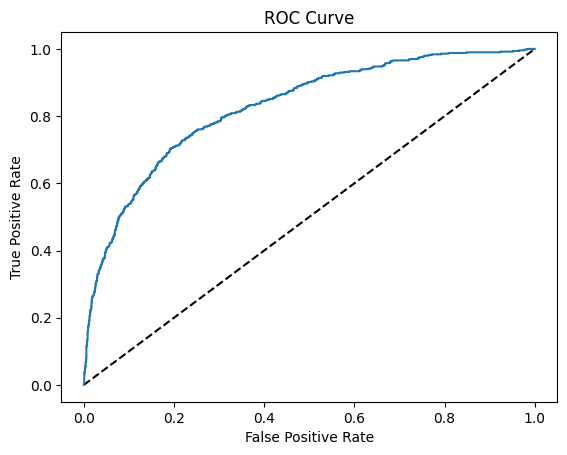

In [154]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [155]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [156]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [157]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)